In [2]:
import pandas as pd
from top2vec import Top2Vec
import top2vec
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import umap

## Top2vec model on description column

We used the Top2Vec model to cluster the description column of nearly 100,000 records. Initially, the model returned 640 topics, which seemed excessive. I suspected this might be due to the min_count parameter being too low (default is 50), so I increased it to 300. However, the number of topics only decreased slightly to 501, which didn’t make a significant difference. As a result, I decided to proceed with the default setting.

In [3]:
# load the data

df = pd.read_csv("../data/csv/sample_100k_v2.csv")
documents = df["Description"].dropna().astype(str).tolist()

In [3]:
print(len(documents))

99968


In [4]:
# 2. Using Top2Vec Model to show the number of topic
model = Top2Vec(documents, embedding_model='doc2vec', 
                speed='learn', workers=4)
print(f"Number of topics found in description: {model.get_num_topics()}")

2025-05-13 20:22:53,042 - top2vec - INFO - Pre-processing documents for training
2025-05-13 20:23:08,604 - top2vec - INFO - Creating joint document/word embedding
2025-05-13 20:34:58,881 - top2vec - INFO - Creating lower dimension embedding of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 20:36:40,515 - top2vec - INFO - Finding dense areas of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 20:36:48,092 - top2vec - INFO

Number of topics found in description: 640


### Keywords of the Top 10 Most Frequent Topics

To facilitate interpretation of the clustering results, we extracted representative keywords from the 10 most prevalent topics. Additionally, word clouds were generated for the top three topics to provide a more intuitive overview of their semantic focus.

The most frequent topic appears to center around crime fiction, while the second emphasizes faster shipping and improved customer service. The third topic is associated with educational materials for students. Notably, most of the extracted keywords have similarity scores exceeding 0.5, indicating that they are highly representative of their respective clusters.

In [5]:
topic_sizes, topic_nums = model.get_topic_sizes()

top_n = 10
sorted_idx = np.argsort(topic_sizes)[::-1]
top_topic_nums = [topic_nums[i] for i in sorted_idx[:top_n]]

topics_words, word_scores, topic_ids = model.get_topics()

# Print 10 most popular topics
for i in range(len(topic_ids)):
    if topic_ids[i] in top_topic_nums:
        print(f"\n🔥 Topic #{topic_ids[i]} ({topic_sizes[topic_nums.tolist().index(topic_ids[i])]} docs)")
        for word, score in zip(topics_words[i][:10], word_scores[i][:10]):
            print(f"  {word:15s}  (score: {score:.4f})")


🔥 Topic #0 (4427 docs)
  she              (score: 0.6191)
  finds            (score: 0.6161)
  him              (score: 0.6123)
  dangerous        (score: 0.6041)
  murder           (score: 0.6040)
  soon             (score: 0.6025)
  deadly           (score: 0.5891)
  her              (score: 0.5888)
  herself          (score: 0.5862)
  desperate        (score: 0.5834)

🔥 Topic #1 (4367 docs)
  faster           (score: 0.5502)
  shipping         (score: 0.5419)
  service          (score: 0.5047)
  better           (score: 0.4919)
  wie              (score: 0.2865)
  er               (score: 0.2701)
  einer            (score: 0.2688)
  auch             (score: 0.2626)
  zu               (score: 0.2591)
  sie              (score: 0.2567)

🔥 Topic #2 (2041 docs)
  students         (score: 0.6447)
  examples         (score: 0.6180)
  learning         (score: 0.5859)
  exercises        (score: 0.5784)
  mathematics      (score: 0.5714)
  mathematical     (score: 0.5592)
  grammar         

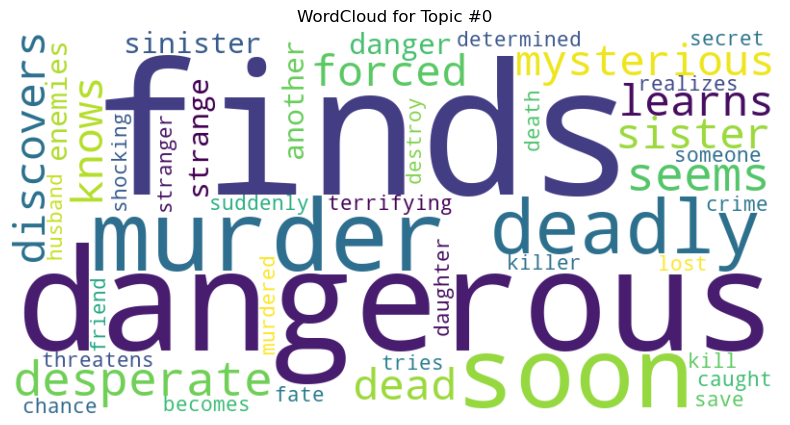

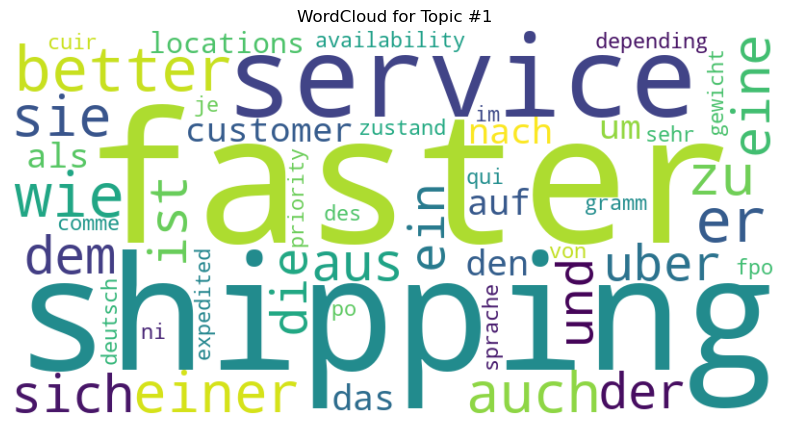

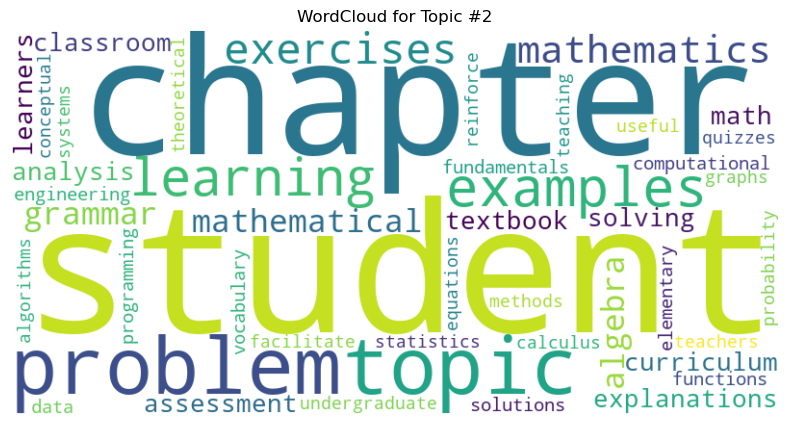

In [6]:
topics_words, _, topic_nums = model.get_topics()

for i in range(3):  
    text = " ".join(topics_words[i])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic #{topic_nums[i]}")
    plt.show()

### UMAP visualization of Description

The UMAP projection presented below illustrates the semantic distribution of all topics generated by the Top2Vec model based on the description field. Each point represents a learned topic vector in a two-dimensional semantic space, where the relative distance between points reflects their semantic similarity.

The visualization reveals a number of well-separated clusters, suggesting that the model has successfully identified distinct topic groupings within the data. Several dense and compact clusters can be observed, particularly in the lower-left and lower-right regions, indicating high semantic coherence among those topics. Meanwhile, the central region contains more loosely connected clusters, which may correspond to broader or more overlapping themes.

Notably, the presence of clearly defined boundaries between many clusters implies that the model was effective in distinguishing between major thematic categories within the dataset. This structure supports the use of these topics for downstream tasks such as classification, content exploration, or recommendation.

C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


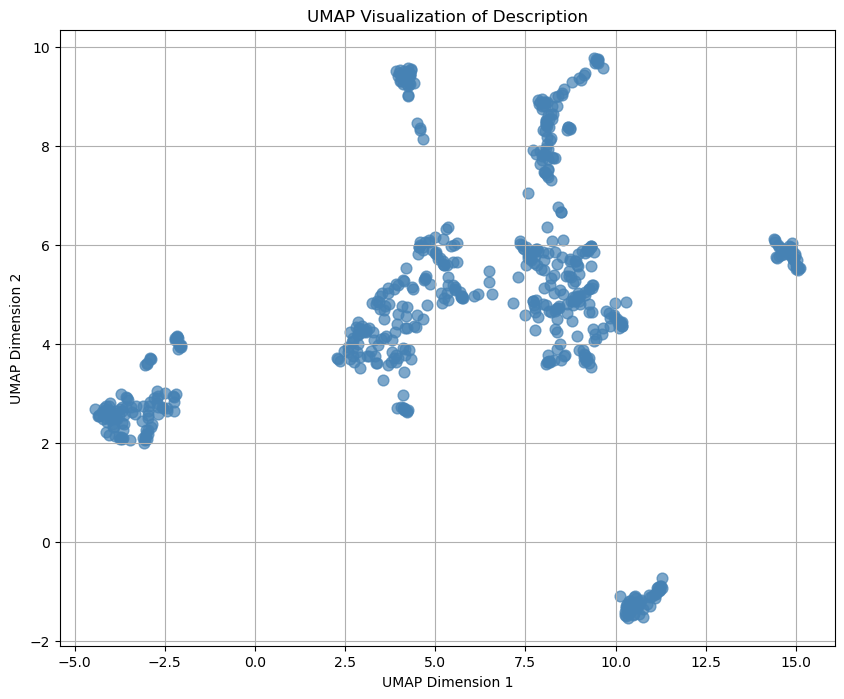

In [7]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(model.topic_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='steelblue', s=60, alpha=0.7)

# Optionally label each reduced topic
#for i, (x, y) in enumerate(embedding):
#    plt.text(x + 0.01, y + 0.01, f"{i}", fontsize=9)

plt.title("UMAP Visualization of Description")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

### Reducing the Number of Topics to 50

Given that over 600 topics may be too granular for effective interpretation, we explored reducing the number of topics to evaluate the impact on clustering structure and semantic coherence. Specifically, we considered three reduction scenarios: 30, 50, and 100 topics.

To achieve this, we used the hierarchical_topic_reduction() method provided by the Top2Vec model, which iteratively merges semantically similar topics while preserving the most representative ones. This allows us to analyze the trade-off between topic granularity and interpretability in a controlled manner.

In [8]:
hierarchy = model.hierarchical_topic_reduction(num_topics=50)

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 590/590 [09:00<00:00,  1.09it/s]


In [9]:
def get_reduced_topic_keywords(model, hierarchy, topn=10):
    """
    Aggregate representative keywords for reduced topics using Top2Vec's hierarchical_topic_reduction.

    Parameters:
        model (Top2Vec): A trained Top2Vec model.
        hierarchy (List[List[int]]): Output of model.hierarchical_topic_reduction(num_topics=...).
        topn (int): Number of most common keywords to return per reduced topic.

    Returns:
        dict: Mapping of reduced topic index to list of top representative keywords.
    """
    # Get original topics (full top 50 words per topic)
    topics_words, word_scores, topic_nums = model.get_topics()

    # Map topic_num to its corresponding words
    topic_id_to_words = {tid: words for tid, words in zip(topic_nums, topics_words)}

    reduced_topic_keywords = {}

    # Merge original topic keywords according to hierarchy
    for new_topic_id, original_topic_ids in enumerate(hierarchy):
        words = []
        for topic_id in original_topic_ids:
            words.extend(topic_id_to_words[topic_id])
        from collections import Counter
        most_common = [word for word, _ in Counter(words).most_common(topn)]
        reduced_topic_keywords[new_topic_id] = most_common

    return reduced_topic_keywords


Here we print the top keywords for each of the 50 reduced topics generated using the hierarchical_topic_reduction() method in the Top2Vec model. Each line corresponds to a distinct semantic cluster, with the associated keywords representing the most relevant terms within that topic. The results show clear and coherent groupings, covering a wide range of themes such as crime fiction and family narratives (Topic 0), shipping and customer service (Topic 1), educational materials (Topic 4), comic characters and entertainment (Topic 10), religious texts (Topic 17), mental health and therapy (Topic 20), clothing and fashion (Topic 29), and personal care products (Topic 32). Most topics are well-formed and interpretable.

In [10]:
reduced_keywords = get_reduced_topic_keywords(model, hierarchy, topn=10)

for topic_id, keywords in reduced_keywords.items():
    print(f"Reduced Topic {topic_id}: {', '.join(keywords)}")

Reduced Topic 0: mysterious, her, she, soon, herself, daughter, husband, sister, finds, until
Reduced Topic 1: faster, shipping, service, better, wie, er, einer, auch, zu, sie
Reduced Topic 2: hardcover, paperback, stock, shipping, printing, hardback, postage, pp, overseas, octavo
Reduced Topic 3: dress, chic, skirt, blouse, lends, midi, ruffled, flowy, effortless, elegance
Reduced Topic 4: learning, quizzes, exercises, solutions, algebra, textbook, student, students, examples, solving
Reduced Topic 5: highlighting, may, markings, copy, intact, codes, shelf, underlining, minor, curled
Reduced Topic 6: toe, slingback, buckle, chic, heeled, strappy, platform, block, ankle, pump
Reduced Topic 7: ahead, frames, warranty, plastic, curve, months, shield, staying, smartbuyglasses, complimentary
Reduced Topic 8: leather, sole, round, rubber, toe, suede, lining, textile, square, pebbled
Reduced Topic 9: decor, space, outdoor, spaces, sofa, bedroom, transitional, tufted, dining, stabilized
Reduc

In [11]:
def get_reduced_topic_vectors(model, hierarchy):
    """
    Compute reduced topic vectors by averaging original topic vectors in each group.

    Parameters:
        model (Top2Vec): A trained Top2Vec model.
        hierarchy (List[List[int]]): Output from model.hierarchical_topic_reduction()

    Returns:
        List[np.ndarray]: List of averaged topic vectors for each reduced topic.
    """
    # Get original topic vectors and their topic numbers
    topic_vectors = model.topic_vectors
    _, _, topic_nums = model.get_topics()
    topic_id_to_vector = {tid: vec for tid, vec in zip(topic_nums, topic_vectors)}

    # Compute averaged vectors for each reduced topic
    reduced_vectors = []
    for group in hierarchy:
        group_vectors = [topic_id_to_vector[tid] for tid in group]
        avg_vector = np.mean(group_vectors, axis=0)
        reduced_vectors.append(avg_vector)

    return reduced_vectors

### UMAP Visualization After Topic Reduction (50 Topics)

While the reduced-topic visualization (50 topics) offers a cleaner and more interpretable layout, the original full-topic UMAP (600+ topics) reveals more natural clustering patterns. The unreduced version displays distinct semantic groupings with tighter local clusters, suggesting stronger topic separability. In contrast, the reduced topics tend to form a linear structure due to semantic averaging, which simplifies interpretation but may obscure fine-grained distinctions.

C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


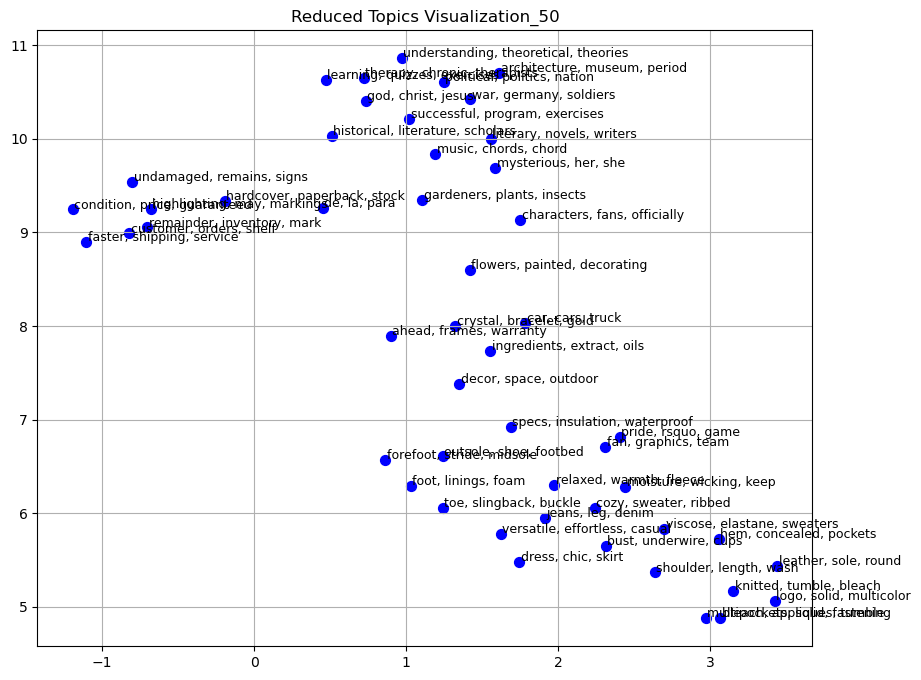

In [12]:
reduced_vectors = get_reduced_topic_vectors(model, hierarchy)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', s=50)
for i, (x, y) in enumerate(embedding):
    label = ", ".join(reduced_keywords[i][:3])  # show top 3 words
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)
plt.title("Reduced Topics Visualization_50")
plt.grid(True)
plt.show()

C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


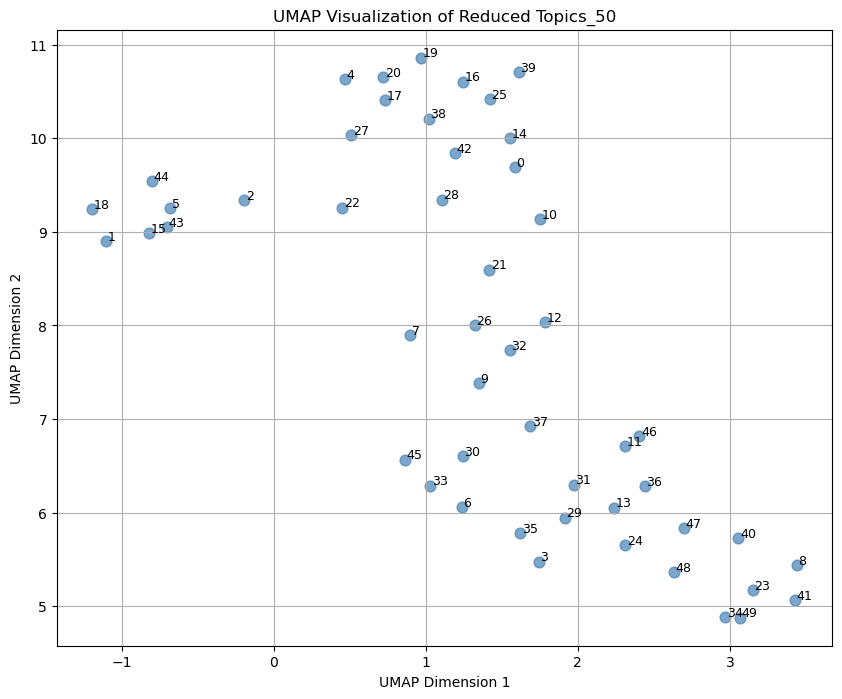

In [13]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='steelblue', s=60, alpha=0.7)

# Optionally label each reduced topic
for i, (x, y) in enumerate(embedding):
    plt.text(x + 0.01, y + 0.01, f"{i}", fontsize=9)

plt.title("UMAP Visualization of Reduced Topics_50")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

### UMAP Visualization After Topic Reduction (100 Topics)

We compared UMAP visualizations across three levels of topic granularity: the original 600+ topics, a reduced set of 100, and a further reduction to 50. The full-topic map reveals rich semantic structure but is visually dense and difficult to interpret. The 100-topic version strikes a strong balance, preserving several meaningful clusters while improving clarity. In contrast, the 50-topic map offers the most interpretable layout, but topic points are more evenly spaced and less clustered, suggesting a loss of fine-grained distinctions.

In [14]:
hierarchy_100 = model.hierarchical_topic_reduction(num_topics=100)

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 540/540 [19:02<00:00,  2.12s/it]


C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


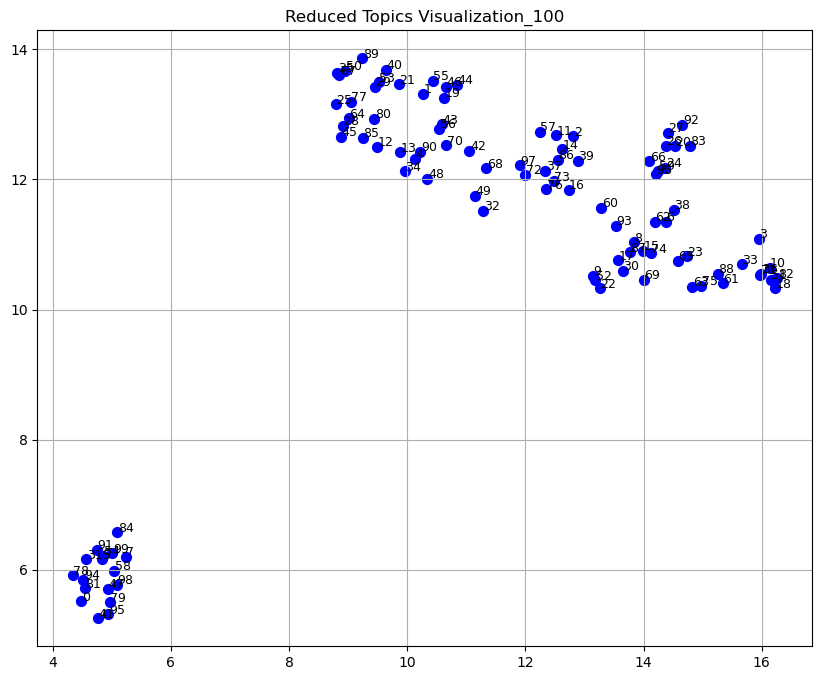

In [15]:
reduced_keywords_100 = get_reduced_topic_keywords(model, hierarchy_100, topn=10)

reduced_vectors_100 = get_reduced_topic_vectors(model, hierarchy_100)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors_100)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', s=50)
for i, (x, y) in enumerate(embedding):
    plt.text(x + 0.01, y + 0.01, f"{i}", fontsize=9)
    
plt.title("Reduced Topics Visualization_100")
plt.grid(True)
plt.show()


In [16]:
topic_sizes, _ = model.get_topic_sizes()

doc_counts_100 = []
for group in hierarchy_100:
    total_docs = sum(topic_sizes[topic_id] for topic_id in group)
    doc_counts_100.append(total_docs)

top10_indices = np.argsort(doc_counts_100)[-10:][::-1] 

print("📌 Top 10 Most Popular Topics (by Document Count):\n")

for idx in top10_indices:
    print(f"🔥 Topic #{idx} ({doc_counts_100[idx]} docs)")
    for word in reduced_keywords_100[idx]:
        print(f" - {word}")
    print()

📌 Top 10 Most Popular Topics (by Document Count):

🔥 Topic #1 (4809 docs)
 - mysterious
 - her
 - she
 - soon
 - herself
 - daughter
 - husband
 - sister
 - finds
 - until

🔥 Topic #0 (4367 docs)
 - faster
 - shipping
 - service
 - better
 - wie
 - er
 - einer
 - auch
 - zu
 - sie

🔥 Topic #2 (2764 docs)
 - ahead
 - frames
 - warranty
 - plastic
 - curve
 - months
 - shield
 - staying
 - smartbuyglasses
 - complimentary

🔥 Topic #3 (2444 docs)
 - cleated
 - origin
 - parts
 - toeline
 - textile
 - flatform
 - round
 - animal
 - non
 - multicolor

🔥 Topic #4 (2400 docs)
 - learning
 - quizzes
 - exercises
 - solutions
 - algebra
 - textbook
 - student
 - students
 - examples
 - solving

🔥 Topic #5 (2070 docs)
 - may
 - markings
 - intact
 - highlighting
 - shelf
 - copy
 - cover
 - minor
 - codes
 - pages

🔥 Topic #8 (1989 docs)
 - sweater
 - cozy
 - ribbed
 - knit
 - cardigan
 - comfy
 - wardrobe
 - versatile
 - outfit
 - neck

🔥 Topic #15 (1967 docs)
 - jeans
 - leg
 - denim
 - slim
 

### UMAP Visualization After Topic Reduction (30 Topics)

The 30-topic reduction offers the cleanest and most interpretable visualization, but sacrifices semantic granularity and clustering structure. It is well-suited for high-level summarization but less effective for exploring nuanced topic relationships.

In [17]:
hierarchy_30 = model.hierarchical_topic_reduction(num_topics=30)

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 610/610 [08:57<00:00,  1.14it/s]


C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


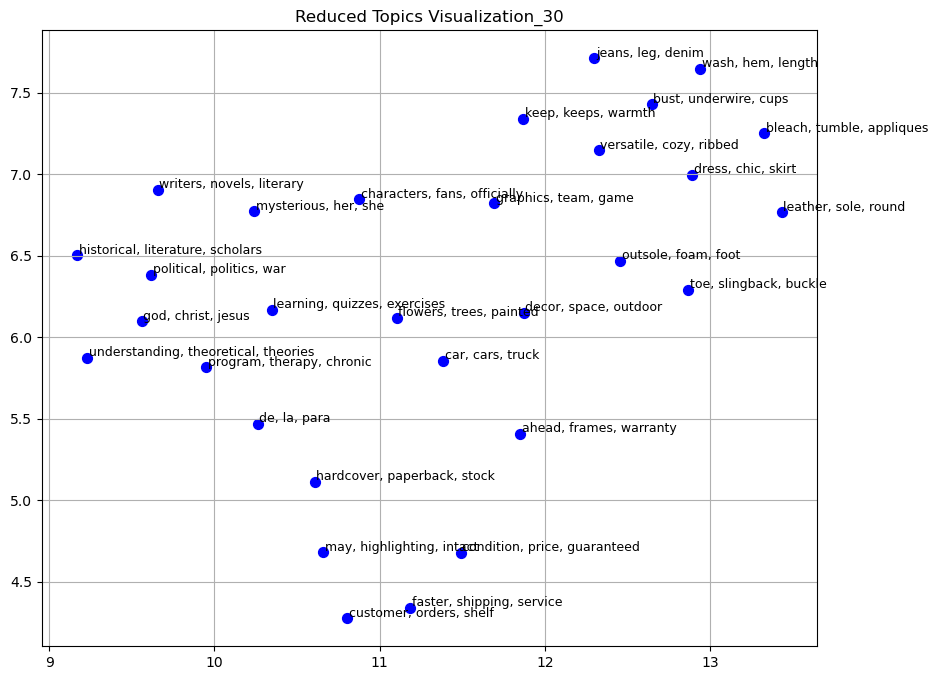

In [18]:
reduced_keywords_30 = get_reduced_topic_keywords(model, hierarchy_30, topn=10)

reduced_vectors_30 = get_reduced_topic_vectors(model, hierarchy_30)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors_30)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', s=50)
for i, (x, y) in enumerate(embedding):
    label = ", ".join(reduced_keywords_30[i][:3])  # show top 3 words
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)
plt.title("Reduced Topics Visualization_30")
plt.grid(True)
plt.show()

### Top2Vec on descriptions excluding the "Books" category

After discussing with our capstone partner, we decided to run the Top2Vec model on the description column, excluding entries from the Books category. Interestingly, the model returned 662 topics, which is even more than when Books were included.

Upon inspecting the top 10 most frequent topics, we observed that the topic containing keywords like faster shipping and better service is now the most prominent, with 4,357 documents. The second most common topic drops sharply to 1,783 documents, and appears to center around family relationships.

In conclusion, excluding Books did not lead to a meaningful reduction in the number of topics. In fact, the document count per topic has decreased overall compared to the original model that included Books.

In [6]:
documents_no_books = df[~df["Category"].str.contains(
    "Books", na=False, case=False)]["Description"].dropna().astype(str).tolist()
print(len(documents_no_books))

89659


In [8]:
model_no_books = Top2Vec(documents_no_books, embedding_model='doc2vec', 
                speed='learn', workers=4)
print(f"Number of topics found in description excluding books: {model_no_books.get_num_topics()}")

2025-05-14 15:19:31,202 - top2vec - INFO - Pre-processing documents for training
2025-05-14 15:19:43,050 - top2vec - INFO - Creating joint document/word embedding
2025-05-14 15:28:30,699 - top2vec - INFO - Creating lower dimension embedding of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-14 15:29:18,508 - top2vec - INFO - Finding dense areas of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-14 15:29:23,782 - top2vec - INFO

Number of topics found in description excluding books: 662


In [9]:
# Print the most frequent words for top 10 popular topics

topic_sizes, topic_nums = model_no_books.get_topic_sizes()

top_n = 10
sorted_idx = np.argsort(topic_sizes)[::-1]
top_topic_nums = [topic_nums[i] for i in sorted_idx[:top_n]]

topics_words, word_scores, topic_ids = model_no_books.get_topics()

# Print 10 most popular topics
for i in range(len(topic_ids)):
    if topic_ids[i] in top_topic_nums:
        print(f"\n🔥 Topic #{topic_ids[i]} ({topic_sizes[topic_nums.tolist().index(topic_ids[i])]} docs)")
        for word, score in zip(topics_words[i][:10], word_scores[i][:10]):
            print(f"  {word:15s}  (score: {score:.4f})")


🔥 Topic #0 (4357 docs)
  shipping         (score: 0.5375)
  service          (score: 0.5261)
  faster           (score: 0.5204)
  better           (score: 0.5004)
  depending        (score: 0.2271)
  availability     (score: 0.2200)
  locations        (score: 0.2192)
  stock            (score: 0.2187)
  multiple         (score: 0.1986)
  uk               (score: 0.1892)

🔥 Topic #1 (1783 docs)
  she              (score: 0.7089)
  her              (score: 0.6763)
  herself          (score: 0.6610)
  finds            (score: 0.6339)
  him              (score: 0.6101)
  sister           (score: 0.5904)
  seems            (score: 0.5887)
  knows            (score: 0.5863)
  isn              (score: 0.5752)
  father           (score: 0.5751)

🔥 Topic #2 (1604 docs)
  parts            (score: 0.7375)
  origin           (score: 0.7156)
  toeline          (score: 0.7066)
  cleated          (score: 0.6946)
  animal           (score: 0.6740)
  textile          (score: 0.6541)
  contains        

## top2vec on Name

When min_count was set to 50, the model produced over 1,000 topics. Increasing the value to 70 reduced the number of topics to 878, but the clustering performance remained unsatisfactory. Many of the top topics had relatively low relevance scores, and the UMAP visualizations appeared highly scattered, indicating weak semantic grouping. Additionally, applying topic reduction did not significantly improve the overall structure or interpretability.

In [19]:
names = df["Name"].dropna().astype(str).tolist()
model_names = Top2Vec(names, embedding_model='doc2vec', 
                speed='learn', workers=4, min_count=70)
print(f"Number of topics found for names column: {model_names.get_num_topics()}")

2025-05-13 21:14:12,519 - top2vec - INFO - Pre-processing documents for training
2025-05-13 21:14:17,556 - top2vec - INFO - Creating joint document/word embedding
2025-05-13 21:17:48,253 - top2vec - INFO - Creating lower dimension embedding of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 21:18:19,696 - top2vec - INFO - Finding dense areas of documents
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-13 21:18:30,241 - top2vec - INFO

Number of topics found for names column: 878


In [20]:
topic_sizes, topic_nums = model_names.get_topic_sizes()

top_n = 10
sorted_idx = np.argsort(topic_sizes)[::-1]
top_topic_nums = [topic_nums[i] for i in sorted_idx[:top_n]]

topics_words, word_scores, topic_ids = model_names.get_topics()

# Print 10 most popular topics
for i in range(len(topic_ids)):
    if topic_ids[i] in top_topic_nums:
        print(f"\n🔥 Topic #{topic_ids[i]} ({topic_sizes[topic_nums.tolist().index(topic_ids[i])]} docs)")
        for word, score in zip(topics_words[i][:10], word_scores[i][:10]):
            print(f"  {word:15s}  (score: {score:.4f})")


🔥 Topic #0 (900 docs)
  decorative       (score: 0.8001)
  suitable         (score: 0.7974)
  pcs              (score: 0.7961)
  decoration       (score: 0.7842)
  material         (score: 0.7740)
  resin            (score: 0.7698)
  shaped           (score: 0.7694)
  ornaments        (score: 0.7671)
  parties          (score: 0.7658)
  accessory        (score: 0.7610)

🔥 Topic #1 (758 docs)
  testament        (score: 0.0092)
  commentary       (score: -0.0363)
  philosophy       (score: -0.0537)
  collected        (score: -0.0568)
  der              (score: -0.0643)
  medieval         (score: -0.0701)
  carolina         (score: -0.0712)
  paul             (score: -0.0750)
  cambridge        (score: -0.0756)
  south            (score: -0.0768)

🔥 Topic #2 (687 docs)
  brain            (score: 0.4768)
  general          (score: 0.4216)
  medical          (score: 0.4201)
  secrets          (score: 0.4136)
  review           (score: 0.4120)
  mind             (score: 0.4111)
  creating  

C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


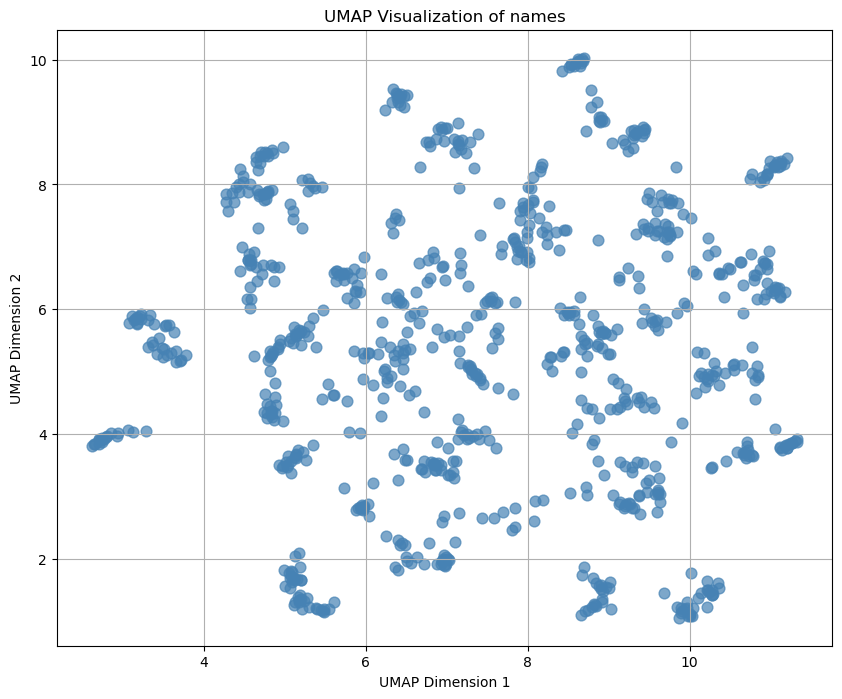

In [21]:
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(model_names.topic_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='steelblue', s=60, alpha=0.7)

# Optionally label each reduced topic
#for i, (x, y) in enumerate(embedding):
#    plt.text(x + 0.01, y + 0.01, f"{i}", fontsize=9)

plt.title("UMAP Visualization of names")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

In [26]:
hierarchy_names_100 = model_names.hierarchical_topic_reduction(num_topics=100)

Reducing topics: 100%|███████████████████████████████████████████████████████████████| 778/778 [15:01<00:00,  1.16s/it]


C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\jyflo\miniforge3\envs\finly\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


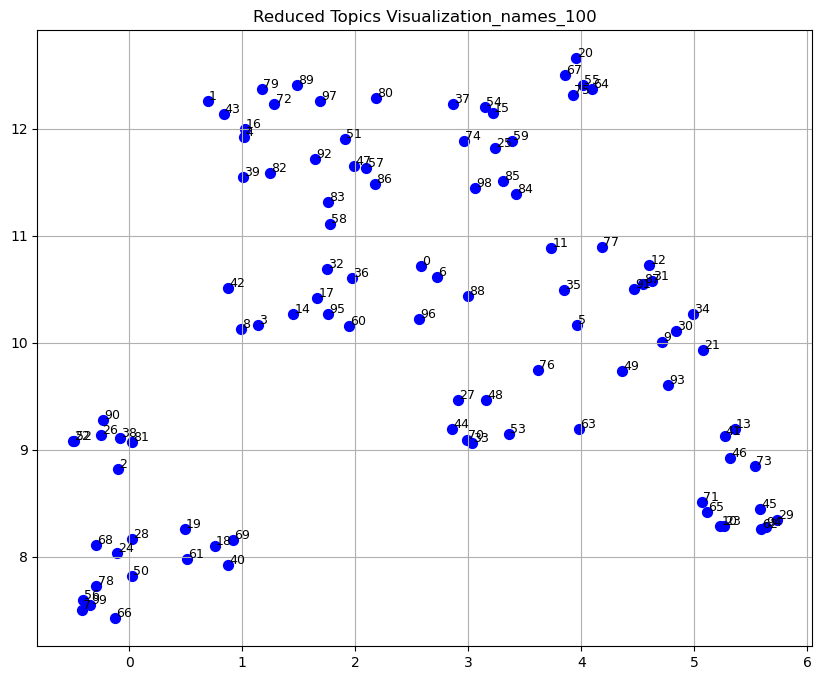

In [29]:
reduced_keywords_names_100 = get_reduced_topic_keywords(model_names, hierarchy_names_100, topn=10)

reduced_vectors_names_100 = get_reduced_topic_vectors(model_names, hierarchy_names_100)

umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding = umap_model.fit_transform(reduced_vectors_names_100)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', s=50)
# Optionally label each reduced topic
for i, (x, y) in enumerate(embedding):
    plt.text(x + 0.01, y + 0.01, f"{i}", fontsize=9)
plt.title("Reduced Topics Visualization_names_100")
plt.grid(True)
plt.show()